In [2]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import random
# import torch.nn.functional as F
from torchvision.transforms import functional as F

In [ ]:
# !pip install --upgrade albumentations
# import albumentations as A

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## To Do: 
Do research on augmentations 
and decide to fix trainloader. Make my own train loader class if needed. 

### Build own transforms functions from Scratch borrowing Albumentations code or some other code. More info down below.
### What is collate_fn what does it do.
### Look at what the train functions do https://github.com/pytorch/vision/tree/master/references/detection
### Add to the spreadsheet by getting info about agencies or research that is to help people who suffer from blindness.

* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.geeksforgeeks.org/python-opencv-cv2-rectangle-method/ 

https://stackoverflow.com/questions/56108183/python-opencv-cv2-drawing-rectangle-with-text

small images


bounding_box_dict = dict() #COntain cols 1, 2, 3, 4
{"*.jpeg": [[67, 47, 110, 117], [70, 30, 83, 34], [160, 46, 59, 63]], "*.jpeg"}
label_dict = dict() #COntains dummy variable of strawberry, blackspot
{"*.jpeg": [1, 1, 0, }
Update bouding box then update label in the for loop.
print(strawberry_csv["FreshStrawberries90.jpeg"])

In [4]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Baby Dataset Fruit Defects Dataset .zip", 'r') as zip_ref:
    zip_ref.extractall()

In [68]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, rottenApple_csv_batch_2, rottenApple_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
assert total_row_sum_check == fruit_df.shape[0]
print("DataFrame shape: {}".format(fruit_df.shape))
print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))
  


Checked total rows from all the dataframes combined: 526
DataFrame shape: (526, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 159


In [69]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [70]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

158
158


### Example Pseudo code for an image

For the image below we need 6 bounding boxes for example
Model forms 8. 

https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

``` 
labels = ["Badspots", "Apples"]
labels (after processing) = [0, 1]

output = [{"boxes": [[], [], [], [], [], [], [], []],
          "labels": [0, 0, 0, 0, 1, 1, 0, 0, 0] #Predicted 6 bounding boxes and 2 apples. 
          "scores": [0.98, 0.95 ... 0.05 ] #Here we set a threshold so that bounding boxes with low confidence score are discarded.]            
```
The length of bouding box is determined by the batch size          

Then get the category names

```
class_names = ["Bad_Spots", "Apples", "Bananas", "Strawberry"]
```

Model pretrained load only for (Coco) * Important b/c we need to train on our datatset not on the Coco dataset
```
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                    min_size=args['min_size'])
```


In [ ]:
sorted(labels_dict.keys())[20]

'FreshStrawberries37.jpeg'

get a for loop and loop throufh each image key create a new word 
so like 
a then ap then app then appl then apple and check if each word is in the folder name. 

* get the keys of the dictionary and then put in into self.imgs list. 
Now I can use if statements to build the root. 

Now i have a list of keys
So I can access the bouding boxes and the label list using that key

Create a dataframe with image_keys and roots.

## more Psedo code

Use glob glob to find all the image paths then I can say:
[list of of image paths inside Train]

only one file patg that will end FreshStrawberries37.jpeg

for file_path in glob_path:
  if image_key in file_path (get stuff before last backslash): ("Strawberry")
  then return that file_path
  return file_path

In [ ]:
hhj

{'bboxes': [(5.9999999999999964, 11.0, 74.0, 69.0, 'test'),
  (53.0, 36.0, 15.0, 13.0, 'test'),
  (38.0, 37.0, 13.0, 11.0, 'test'),
  (22.0, 32.0, 14.0, 14.999999999999993, 'test'),
  (23.0, 16.0, 18.0, 12.0, 'test')],
 'image': array([[[1.1764706e-02, 3.8823530e-01, 2.2745098e-01],
         [0.0000000e+00, 3.6078432e-01, 2.0000000e-01],
         [1.5686275e-02, 3.6078432e-01, 2.0392157e-01],
         ...,
         [8.6274512e-02, 4.0392157e-01, 2.9803923e-01],
         [9.8039217e-02, 4.1568628e-01, 3.1764707e-01],
         [9.0196081e-02, 4.0784314e-01, 3.0980393e-01]],
 
        [[0.0000000e+00, 3.8431373e-01, 2.1176471e-01],
         [0.0000000e+00, 3.5686275e-01, 1.9607843e-01],
         [1.1764706e-02, 3.6078432e-01, 2.0392157e-01],
         ...,
         [5.8823530e-02, 3.8039216e-01, 2.6666668e-01],
         [5.8823530e-02, 3.7647060e-01, 2.7058825e-01],
         [5.0980393e-02, 3.6862746e-01, 2.6274511e-01]],
 
        [[0.0000000e+00, 3.7254903e-01, 1.9215687e-01],
         [

In [ ]:
# transform = A.Compose([
#     A.RandomCrop(width=80, height=80),
#     A.HorizontalFlip(p=1),
#     A.RandomRain(), 
#     A.RandomBrightnessContrast(p=0.2),
# ], bbox_params=A.BboxParams(format='coco'))

In [64]:
hhj = cv2.cvtColor(cv2.imread("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples30.jpeg"), cv2.COLOR_BGR2RGB)
# bboy = bounding_box_dict["RottenApples30.jpeg"]
hhj = F.to_tensor(hhj)
hhj = hhj.flip(-1)
bboy = bounding_box_dict["RottenApples30.jpeg"]
bboy = torch.tensor(bboy, dtype= torch.float32)

In [42]:
hhj.size()

torch.Size([3, 100, 100])

In [61]:
#[channels, height, width],
distance = hhj.size(2)
bboy[4][0] = (distance - (bboy[4][0] + bboy[4][2]))

In [65]:
distance = hhj.size(2)
for row in bboy:
  row[0] = (distance - (row[0] + row[2]))

In [66]:
bboy

tensor([[ 9., 22., 83., 77.],
        [56., 47., 15., 13.],
        [41., 48., 13., 11.],
        [25., 43., 14., 15.],
        [26., 27., 18., 12.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


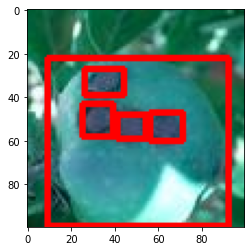

In [67]:
hhj = hhj.permute(1, 2, 0).numpy()
hhj = cv2.cvtColor(hhj, cv2.COLOR_BGR2RGB)
for i, box in enumerate(bboy):
      color = 255
      cv2.rectangle(
          hhj,
          (int(box[0]), int(box[1])),
          (int(box[0]) + int(box[2]), int(int(box[1])) + int(box[3])),
          color, 2
      )
plt.imshow(hhj)


In [ ]:
hhj = cv2.cvtColor(cv2.imread("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples30.jpeg"), cv2.COLOR_BGR2RGB)

## Class function

In [71]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(pair_of_coord[2] * pair_of_coord[3])
  return area_of_each_bb

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())
    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths)

    # print(img_path)
    # print(idx)
    # print(self.imgs_key[idx])
    
    img = Image.open(img_path).convert("RGB") ## No Image path sometimes

    boxes = torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32)
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      img, target = self.transforms(img, target)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

### The Problem involved the differences between tensor, PIL, Numpy, and OpenCV and how they load images. 

Convert Tensor Image to numpy to do openCV operations. 
https://discuss.pytorch.org/t/convert-image-tensor-to-numpy-image-array/22887/2

PIL Loaded (y, x)
Numpy (x, y, d)
Torch (d, x, y) <- convert image to tensor and switch axis
Then convert to openCV since openCV can handle only a numpy array. 

Questions: 
Do I have to apply transforms on the labels/ boxes. I see it on the blog but I can't do it. 

Also, why when I take off shuffle does the dateiter fail. Why does it sometimes get a None error.

What I think is that the tensor image is ok. The reason the image flipped is because I Transposed it. When I did not transpose it, the openCV could recognize it b/c it only works well with the numpy shaped images. Therefore, all my code did was to turn that tensor image into something compatible with OpenCV so it can do its manipulations.

In [72]:
def get_transform(train):
    transform = []
    transform.append(ToTensor())
    if train:
        transform.append(RandomHorizontalFlip(0.5))
    return Compose(transform)

https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

This is the functional file (Can also just navigate the github). 

https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/functional.py

This link contains the raw albumentations code that is used to build these transforms

```
class HorizontalFlip(DualTransform):
    """Flip the input horizontally around the y-axis.
    Args:
        p (float): probability of applying the transform. Default: 0.5.
    Targets:
        image, mask, bboxes, keypoints
    Image types:
        uint8, float32
    """

    def apply(self, img, **params):
        if img.ndim == 3 and img.shape[2] > 1 and img.dtype == np.uint8:
            # Opencv is faster than numpy only in case of
            # non-gray scale 8bits images
            return F.hflip_cv2(img)

        return F.hflip(img)

    def apply_to_bbox(self, bbox, **params):
        return F.bbox_hflip(bbox, **params)

    def apply_to_keypoint(self, keypoint, **params):
        return F.keypoint_hflip(keypoint, **params)

    def get_transform_init_args_names(self):
        return ()
```

blog used to talk about albumentations
https://blog.paperspace.com/data-augmentation-for-bounding-boxes/

In [79]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            _,  width = image.shape[-2:]
            image = image.flip(-1)
            for bb_coord in target["boxes"]:
              bb_coord[0] = (width - (bb_coord[0] + bb_coord[2]))
              
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [89]:
def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

np.random.seed(42)
torch.manual_seed(42)
batch_size = 32

# train_transform = transforms.Compose([
#                                       transforms.RandomHorizontalFlip(0.5), 
#                                       transforms.ToTensor()])

# train_transform = Compose([RandomHorizontalFlip(0.5), 
#                            ToTensor()])
                                      


# train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, train_transform)
train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transform(train = True))
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn= collate_fn)

In [85]:
COLORS = [(255, 0, 0) for i in range(len(classes))]
COLORS[0] = (0, 0, 255)

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[0]) + int(box[2]), int(int(box[1])) + int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

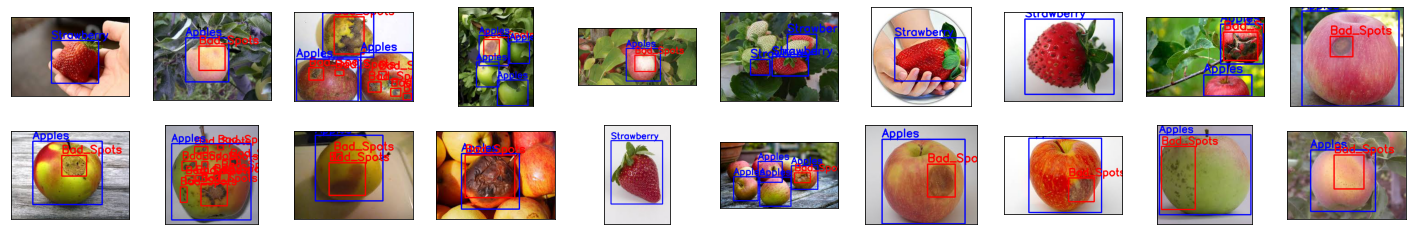

In [90]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = cv2.cvtColor(draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [ ]:

# bounding_box_dict = dict()
# labels_dict = dict()
# classes = ["Black_Spots", "Strawberry"]

# for row_index in range(len(strawberry_csv)): 
#   current_image_file = strawberry_csv.iloc[row_index]["Image_id"]
#   if current_image_file not in bounding_box_dict:
#     bounding_box_dict[current_image_file] = list()
#     labels_dict[current_image_file] = list()
#   bounding_box_dict[current_image_file].append(strawberry_csv.iloc[row_index, 1:5].to_list())
#   labels_dict[current_image_file].append(classes.index(strawberry_csv.iloc[row_index, 0]))

